In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime
import nltk
import time
import logging
import itertools
import gensim

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

%matplotlib inline

In [183]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]# setup train data

# setup train data
def get_raw_text(df, num_words=None):
    raw_text = ''
    for post in df['body']:
        if isinstance(num_words, int):
            post = ' '.join(post.split()[0:num_words])
        raw_text = ' '.join([raw_text, post])
    return raw_text

In [266]:
def show_topics(vecs):
    for vec in vecs:
        print vec[1]
        sorted_topics = sorted(vec[0], key=lambda item: item[1], reverse=True)
        for topic in sorted_topics:
            print '  ', ', '.join(item[0] for item in lda_model.show_topic(topic[0], topn=10))

In [2]:
boston_bomb_df = pd.read_json('data/reddit/boston_comments_2013.03-2013.05.txt', lines=True)
boston_series_df = pd.read_json('data/reddit/boston_comments_2013.10-2013.11.txt', lines=True)
florida_df = pd.read_json('data/reddit/florida_comments_2017.06-2017.10.txt', lines=True)
houston_df = pd.read_json('data/reddit/houston_comments_2017.06-2017.10.txt', lines=True)
miami_df = pd.read_json('data/reddit/miami_comments_2017.06-2017.10.txt', lines=True)
nyc_df = pd.read_json('data/reddit/nyc_comments_2012.08-2012.12.txt', lines=True)
puerto_rico_df = pd.read_json('data/reddit/puerto_rico_comments_2017.06-2017.10.txt', lines=True)
vegas_df = pd.read_json('data/reddit/vegas_comments_2017.06-2017.10.txt', lines=True)

In [3]:
# setup local times
boston_bomb_df['created_at_local'] = pd.to_datetime(boston_bomb_df['created_utc'], unit='s') \
                                     .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
boston_series_df['created_at_local'] = pd.to_datetime(boston_series_df['created_utc'], unit='s') \
                                     .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
florida_df['created_at_local'] = pd.to_datetime(florida_df['created_utc'], unit='s') \
                                     .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
houston_df['created_at_local'] = pd.to_datetime(houston_df['created_utc'], unit='s') \
                                     .dt.tz_localize('UTC').dt.tz_convert('US/Central')
miami_df['created_at_local'] = pd.to_datetime(miami_df['created_utc'], unit='s') \
                                     .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
nyc_df['created_at_local'] = pd.to_datetime(nyc_df['created_utc'], unit='s') \
                                 .dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
puerto_rico_df['created_at_local'] = pd.to_datetime(puerto_rico_df['created_utc'], unit='s') \
                                 .dt.tz_localize('UTC').dt.tz_convert('America/Puerto_Rico')
vegas_df['created_at_local'] = pd.to_datetime(vegas_df['created_utc'], unit='s') \
                                 .dt.tz_localize('UTC').dt.tz_convert('US/Pacific')  

In [14]:
# load up corpus
mm_corpus = gensim.corpora.MmCorpus('./data/wiki_bow.mm')
id2word_wiki = gensim.corpora.dictionary.Dictionary.load('./data/wiki.dictionary')

print mm_corpus

MmCorpus(3880459 documents, 100000 features, 635764655 non-zero entries)


In [143]:
clipped_corpus = gensim.utils.ClippedCorpus(mm_corpus, 3000000)
num_topics=1000
%time lda_model = gensim.models.LdaModel(clipped_corpus, num_topics=num_topics, id2word=id2word_wiki, passes=4)

CPU times: user 10d 21h 23s, sys: 13h 26min 32s, total: 11d 10h 26min 55s
Wall time: 4d 6h 26min 46s


In [144]:
# store models to disk
lda_model.save('./data/lda_reddit_wiki.model')

In [145]:
# load model back
lda_model = gensim.models.LdaModel.load('./data/lda_reddit_wiki.model')

In [211]:
def get_topic_vectors(df=None, start_date=None, end_date=None, window_size=None, post_length=None):
    start_window = start_date
    end_window = start_date + datetime.timedelta(days=window_size - 1)
    
    topic_df = df[(df['created_at_local'].dt.date >= start_date) & \
                 (df['created_at_local'].dt.date <= end_date)]
    
    tokens = tokenize(get_raw_text(topic_df, num_words=post_length))
    bow_vector = id2word_wiki.doc2bow(tokens)
    full_lda_vector = lda_model[bow_vector]
    
    lda_vecs = []
    while end_window <= end_date:
        #print start_window, ' - ', end_window
        
        topic_df = df[(df['created_at_local'].dt.date >= start_window) & \
                 (df['created_at_local'].dt.date <= end_window)]
        
        tokens = tokenize(get_raw_text(topic_df, num_words=post_length))
        # transform text into the bag-of-words space
        bow_vector = id2word_wiki.doc2bow(tokens)
        lda_vector = lda_model[bow_vector]
        lda_vecs.append((lda_vector, start_window))

        start_window = end_window + datetime.timedelta(days=1)
        end_window = start_window + datetime.timedelta(days=window_size - 1) 
    
    return full_lda_vector, lda_vecs

In [212]:
%%time

start_date = datetime.date(2012, 9, 1)
end_date = datetime.date(2012, 12, 30)
window_size = 3 # days

nyc_lda, nyc_vecs = get_topic_vectors(df=nyc_df, start_date=start_date, 
                             end_date=end_date, post_length=30,
                             window_size=window_size)

CPU times: user 2min 17s, sys: 1min, total: 3min 18s
Wall time: 2min 37s


In [267]:
show_topics(nyc_vecs)

2012-09-01
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   borough, metropolitan, brooklyn, manhattan, christie, nyc, harlem, stony, bronx, quinnipiac
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   com, http, www, org, html, net, https, gov, php, edu
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   required, laws, regulations, allowed, registered, registration, regulation, permit, banned, permitted
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   friend, friends, love, 

   com, http, www, org, html, net, https, gov, php, edu
   borough, metropolitan, brooklyn, manhattan, christie, nyc, harlem, stony, bronx, quinnipiac
   criticism, views, controversy, debate, argued, criticized, controversial, opinion, opposed, issues
   drug, drugs, trafficking, tobacco, smoking, addiction, cocaine, marijuana, substance, illegal
2012-09-22
   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   com, http, www, org, html, net, https, gov, php, edu
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   user, users, app, android, support, features, allows, available, software, application
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   borough, metropolitan, brookl

   street, avenue, neighborhood, streets, downtown, ave, boulevard, corner, neighborhoods, plaza
2012-10-16
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   announced, got, wanted, decided, revealed, going, week, good, start, months
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   com, http, www, org, html, net, https, gov, php, edu
   borough, metropolitan, brooklyn, manhattan, christie, nyc, harlem, stony, bronx, quinnipiac
   bus, express, transport, metro,

   borough, metropolitan, brooklyn, manhattan, christie, nyc, harlem, stony, bronx, quinnipiac
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   street, avenue, neighborhood, streets, downtown, ave, boulevard, corner, neighborhoods, plaza
   minutes, hours, hour, utc, minute, seconds, watch, clock, duration, gmt
   station, railway, train, trains, rail, railways, stations, track, passenger, locomotive
2012-11-09
   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   allow, required, need, needed, possible, able, provide, available, allows,

   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   com, http, www, org, html, net, https, gov, php, edu
   borough, metropolitan, brooklyn, manhattan, christie, nyc, harlem, stony, bronx, quinnipiac
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   online, internet, content, facebook, media, twitter, available, social, websites, copyright
2012-12-03
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   station, railway, train, trains, rail, railways, 

   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   borough, metropolitan, brooklyn, manhattan, christie, nyc, harlem, stony, bronx, quinnipiac
   com, http, www, org, html, net, https, gov, php, edu
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   bus, express, transport, metro, transit, transportation, buses, routes, tram, route
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   station, railway, train, trains, rail, railways, stations, track, passenger, locomotive
   street, avenue, neighborhood, streets, downtown, ave, boulevard, corner, neighborhoods, plaza


In [214]:
def get_vector_distances(vectors=None, full_lda=None):
    distances = []
    if full_lda is not None: 
        for vec in vectors:
            dist = gensim.matutils.jensen_shannon(full_lda, vec[0], num_features=num_topics)
            distances.append((vec[1], dist)) # date of window, distance
    else:
        for i, vec in enumerate(vectors):
            #print len(vec)
            if i != 0:
                dist = gensim.matutils.jensen_shannon(prev_vec[0], vec[0], num_features=num_topics)
                distances.append((vec[1], dist)) # date of window, distance
            prev_vec = vec
    return distances

In [215]:
#for dist in get_vector_distances(vectors=nyc_vecs):
#    print dist

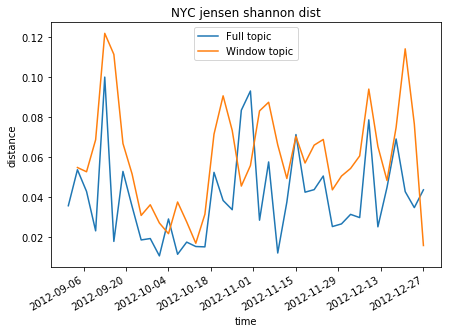

In [241]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(*zip(*get_vector_distances(vectors=nyc_vecs, full_lda=nyc_lda)), label='Full topic')
ax.plot(*zip(*get_vector_distances(vectors=nyc_vecs)), label='Window topic')
ax.set_title('NYC jensen shannon dist')
ax.set_ylabel('distance')
ax.set_xlabel('time')
ax.legend()

fig.autofmt_xdate()

### Florida topics

In [276]:
start_date = datetime.date(2017, 8, 1)
end_date = datetime.date(2017, 9, 30)
window_size = 3 # days

florida_lda, florida_vecs = get_topic_vectors(df=florida_df, start_date=start_date, 
                             end_date=end_date, post_length=30,
                             window_size=window_size)

In [277]:
show_topics(florida_vecs)

2017-08-01
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   florida, miami, cuba, orlando, tampa, cuban, havana, castro, batista, celia
   com, http, www, org, html, net, https, gov, php, edu
   cities, situated, tourism, areas, towns, tourist, nearby, surrounding, visitors, largest
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   summer, days, spring, winter, fall, month, months, autumn, weeks, sanu
   self, person, individual, experience, task, individuals, behavior, pers

   black, white, bracken, wenlock, blackness, spitz, bordered, tokarev, blacker, ebony
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   political, leaders, politics, opposition, leadership, democracy, military, regime, nationalist, leader
2017-08-19
   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   florida, miami, cuba, orlando, tampa, cuban, havana, castro, batista, celia
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   storm, tropical, weather, cyc

   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   com, http, www, org, html, net, https, gov, php, edu
   storm, tropical, weather, cyclone, tornado, rain, winds, depression, homes, damage
   damage, damaged, accident, caused, destroyed, struck, lost, occurred, hit, recovered
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   florida, miami, cuba, orlando, tampa, cuban, havana, castro, batista, celia
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   tells, goes, begins, takes, finds, gets, tries, help, comes, returns
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
2017-09-09
   know, says, told, night, said, come, going, away, things,

   increase, increased, rate, risk, increasing, impact, changes, rates, higher, reduce
   education, schools, secondary, primary, students, elementary, educational, teachers, teacher, grade
   damage, damaged, accident, caused, destroyed, struck, lost, occurred, hit, recovered


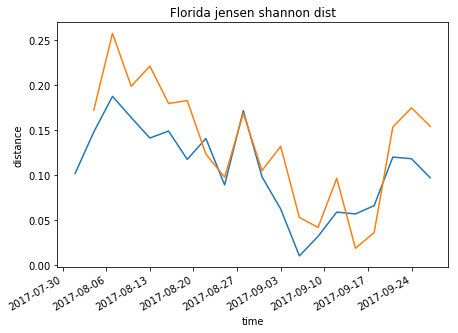

In [278]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(*zip(*get_vector_distances(vectors=florida_vecs, full_lda=florida_lda)), label='Full topic')
ax.plot(*zip(*get_vector_distances(vectors=florida_vecs)), label='Window topic')
ax.set_title('Florida jensen shannon dist')
ax.set_ylabel('distance')
ax.set_xlabel('time')

fig.autofmt_xdate()

## Miami

In [279]:
start_date = datetime.date(2017, 8, 1)
end_date = datetime.date(2017, 9, 30)
window_size = 3 # days

miami_lda, miami_vecs = get_topic_vectors(df=miami_df, start_date=start_date, 
                             end_date=end_date, post_length=30,
                             window_size=window_size)

In [280]:
show_topics(miami_vecs)

2017-08-01
   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   florida, miami, cuba, orlando, tampa, cuban, havana, castro, batista, celia
   car, cars, driver, chevrolet, motor, speedway, toyota, drivers, nascar, auto
   com, http, www, org, html, net, https, gov, php, edu
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   common, usually, term, example, referred, generally, similar, commonly, typically, refers
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   water, supply, dry, wet, pump, fresh, float, pumping, pumps, floating
   allow, required, need, needed, possible, able, provide, available, allows, allowing
2017-08-04
   know, says, told, night, said, come, going, away, things, room
   gu

   announced, got, wanted, decided, revealed, going, week, good, start, months
   florida, miami, cuba, orlando, tampa, cuban, havana, castro, batista, celia
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   com, http, www, org, html, net, https, gov, php, edu
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   storm, tropical, weather, cyclone, tornado, rain, winds, depression, homes, damage
   bass, custom, ups, vintage, watt, upright, dunlop, pickup, walnut, combo
   black, white, bracken, wenlock, blackness, spitz, bordered, tokarev, blacker, ebony
   tells, goes, begins, takes, finds, gets, tries, help, comes, returns
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
2017-08-28
   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   com, http, www, org, html, net, https,

   storm, tropical, weather, cyclone, tornado, rain, winds, depression, homes, damage
   damage, damaged, accident, caused, destroyed, struck, lost, occurred, hit, recovered
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   bass, custom, ups, vintage, watt, upright, dunlop, pickup, walnut, combo
   com, http, www, org, html, net, https, gov, php, edu
   energy, solar, electricity, capacity, mw, fuel, renewable, efficiency, generation, plant
   network, mobile, communications, networks, communication, wireless, nokia, internet, services, provider
   florida, miami, cuba, orlando, tampa, cuban, havana, castro, batista, celia
   pm, bbc, sunday, saturday, friday, morning, programme, monday, thursday, tuesday
2017-09-18
   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   love, night, girl

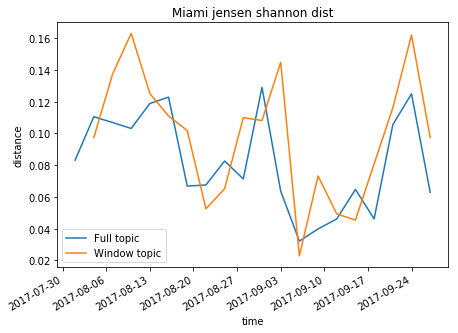

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(*zip(*get_vector_distances(vectors=miami_vecs, full_lda=miami_lda)), label='Full topic')
ax.plot(*zip(*get_vector_distances(vectors=miami_vecs)), label='Window topic')
ax.set_title('Miami jensen shannon dist')
ax.set_ylabel('distance')
ax.set_xlabel('time')
ax.legend()
fig.autofmt_xdate()

## Houston

In [223]:
df_size = houston_df.shape[0]
chosen_idx = np.random.choice(df_size, replace=False, size=df_size/4)
houston_subset_df = houston_df.iloc[chosen_idx]
houston_subset_df.shape

start_date = datetime.date(2017, 8, 1)
end_date = datetime.date(2017, 9, 30)
window_size = 3 # days

houston_lda, houston_vecs = get_topic_vectors(df=houston_subset_df, start_date=start_date, 
                             end_date=end_date, post_length=30,
                             window_size=window_size)

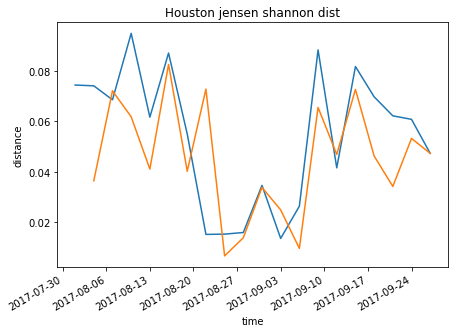

In [244]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(*zip(*get_vector_distances(vectors=houston_vecs, full_lda=houston_lda)), label='Full topic')
ax.plot(*zip(*get_vector_distances(vectors=houston_vecs)), label='Window topic')
ax.set_title('Houston jensen shannon dist')
ax.set_ylabel('distance')
ax.set_xlabel('time')

fig.autofmt_xdate()

In [270]:
show_topics(houston_vecs)

2017-08-01
   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   com, http, www, org, html, net, https, gov, php, edu
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   dish, bread, cheese, sauce, cake, beef, potato, dishes, pizza, michelin
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   texas, houston, austin, dallas, hamilton, antonio, tyler, tx, worth, paso
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   car, cars, driver, chevrolet, motor, speedway, toyota, drivers, nascar,

   texas, houston, austin, dallas, hamilton, antonio, tyler, tx, worth, paso
   water, supply, dry, wet, pump, fresh, float, pumping, pumps, floating
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   allow, required, need, needed, possible, able, provide, available, allows, allowing
2017-08-28
   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   com, http, www, org, html, net, https, gov, php, edu
   damage, damaged, accident, caused, destroyed, struck, lost, occurred, hit, recovered
   dam, reservoir, flood, irrigation, water, dams, floods, flooding, capacity, drainage
   fact, case, certain, question, necessary, matter, claim,

   texas, houston, austin, dallas, hamilton, antonio, tyler, tx, worth, paso
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
2017-09-21
   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   com, http, www, org, html, net, https, gov, php, edu
   dish, bread, cheese, sauce, cake, beef, potato, dishes, pizza, michelin
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   texas, houston, austin, dallas, hamilton, antonio, tyler, tx, worth, paso
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   sold, acquired, owned, sale, purchased, bought, purchase, announced, sell, subsid

## Puerto Rico

In [228]:
start_date = datetime.date(2017, 9, 1)
end_date = datetime.date(2017, 10, 30)
window_size = 3 # days

pr_lda, pr_vecs = get_topic_vectors(df=puerto_rico_df, start_date=start_date, 
                             end_date=end_date, post_length=30,
                             window_size=window_size)

In [271]:
show_topics(pr_vecs)

2017-09-01
   se, pa, si, ne, ba, ka, ni, cohen, ra, ko
   know, says, told, night, said, come, going, away, things, room
   el, del, nacional, las, los, universidad, plaza, colegio, casa, monte
   josé, carlos, juan, luis, cruz, miguel, maría, antonio, fernando, garcía
   la, rochelle, ogier, amis, musique, remi, stanislas, ninh, après, étoile
   en, iceland, er, viking, det, med, icelandic, karin, den, smiley
   kenya, uganda, es, tu, tanzania, kenyan, nairobi, ol, rwanda, dar
   replaced, lo, lighthouse, beacon, rohan, cro, keepers, ponies, kendal, polaris
   ride, drop, roller, val, una, coaster, uno, hen, amusement, vida
   spanish, spain, madrid, rey, valencia, segunda, división, del, españa, granada
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   hotel, las, vegas, nevada, inn, resort, casino, hotels, spa, paradise
   continued, despite, saw, success, successful, remained, eventually, soon, brought, followed
   los, angeles, california, ucla, hollywood, fresno

   damage, damaged, accident, caused, destroyed, struck, lost, occurred, hit, recovered
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   en, iceland, er, viking, det, med, icelandic, karin, den, smiley
   la, rochelle, ogier, amis, musique, remi, stanislas, ninh, après, étoile
   puerto, rico, juan, reyes, rivera, torres, rican, ppd, hernández, rl
   storm, tropical, weather, cyclone, tornado, rain, winds, depression, homes, damage
2017-09-22
   know, says, told, night, said, come, going, away, things, room
   com, http, www, org, html, net, https, gov, php, edu
   online, internet, content, facebook, media, twitter, available, social, websites, copyright
   announced, got, wanted, decided, revealed, going, week, good, start, months
   el, del, nacional, las, los, universidad, plaza, colegio, casa, monte
   josé, carlos, juan, luis, cruz, miguel, maría, antonio, fernando, garcía
   damage, damaged, accident, caused, destroyed, struck, lost, occurred, hit, recovered
  

   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   com, http, www, org, html, net, https, gov, php, edu
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   puerto, rico, juan, reyes, rivera, torres, rican, ppd, hernández, rl
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   josé, carlos, juan, luis, cruz, miguel, maría, antonio, fernando, garcía
   damage, damaged, accident, caused, destroyed, struck, lost, occurred, hit, recovered
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   el, del, nacional, las, los, universidad, plaza, colegio, casa, monte
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   se, pa, si, ne, ba, ka, ni, cohen, ra, ko
   energy, solar, electricity, capacity, mw, fuel, renewable, efficiency, generation, plant
   online, internet, content, facebook, media, twitter, avai

   kenya, uganda, es, tu, tanzania, kenyan, nairobi, ol, rwanda, dar
   com, http, www, org, html, net, https, gov, php, edu
   ram, yo, baba, tara, guru, amar, malik, nag, bharat, kk
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   online, internet, content, facebook, media, twitter, available, social, websites, copyright


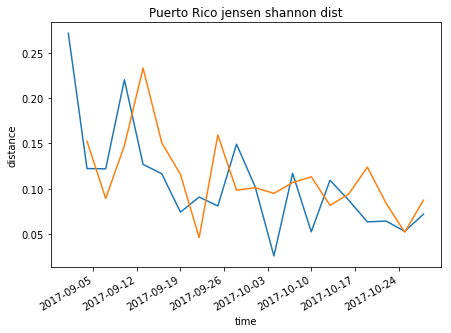

In [246]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(*zip(*get_vector_distances(vectors=pr_vecs, full_lda=pr_lda)), label='Full topic')
ax.plot(*zip(*get_vector_distances(vectors=pr_vecs)), label='Window topic')
ax.set_title('Puerto Rico jensen shannon dist')
ax.set_ylabel('distance')
ax.set_xlabel('time')

fig.autofmt_xdate()

## Vegas

In [230]:
start_date = datetime.date(2017, 9, 1)
end_date = datetime.date(2017, 10, 30)
window_size = 3 # days

vegas_lda, vegas_vecs = get_topic_vectors(df=vegas_df, start_date=start_date, 
                             end_date=end_date, post_length=30,
                             window_size=window_size)

In [272]:
show_topics(vegas_vecs)

2017-09-01
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   hotel, las, vegas, nevada, inn, resort, casino, hotels, spa, paradise
   com, http, www, org, html, net, https, gov, php, edu
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   online, internet, content, facebook, media, twitter, available, social, websites, copyright
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   user, users, app, android, support, features, allows, available, software, application
2017-09-04
   know, says, told, night, said, come, going, aw

   love, night, girl, let, baby, good, live, kiss, beautiful, come
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   hotel, las, vegas, nevada, inn, resort, casino, hotels, spa, paradise
   com, http, www, org, html, net, https, gov, php, edu
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   bass, custom, ups, vintage, watt, upright, dunlop, pickup, walnut, combo
   cover, dennis, drew, illustrated, covers, strip, drawing, graphic, thomson, illustrations
   road, route, highway, roads, intersection, interchange, terminus, routes, continues, runs
2017-09-28
   know, says, told, night, said, come, going, away, things, room
   announced, got, wanted, decided, revealed, going, week, good, start, months
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   hotel, las, vegas, nevada, inn,

   announced, got, wanted, decided, revealed, going, week, good, start, months
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   hotel, las, vegas, nevada, inn, resort, casino, hotels, spa, paradise
   com, http, www, org, html, net, https, gov, php, edu
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   online, internet, content, facebook, media, twitter, available, social, websites, copyright
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   user, users, app, android, support, features, allows, available, software, application
2017-10-22
   know, says, told, night, said, 

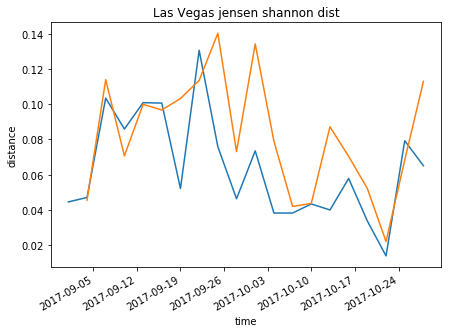

In [247]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(*zip(*get_vector_distances(vectors=vegas_vecs, full_lda=vegas_lda)), label='Full topic')
ax.plot(*zip(*get_vector_distances(vectors=vegas_vecs)), label='Window topic')
ax.set_title('Las Vegas jensen shannon dist')
ax.set_ylabel('distance')
ax.set_xlabel('time')

fig.autofmt_xdate()

## Boston bombing

In [250]:
start_date = datetime.date(2013, 3, 15)
end_date = datetime.date(2013, 5, 15)
window_size = 3 # days

boston_lda, boston_vecs = get_topic_vectors(df=boston_bomb_df, start_date=start_date, 
                             end_date=end_date, post_length=30,
                             window_size=window_size)

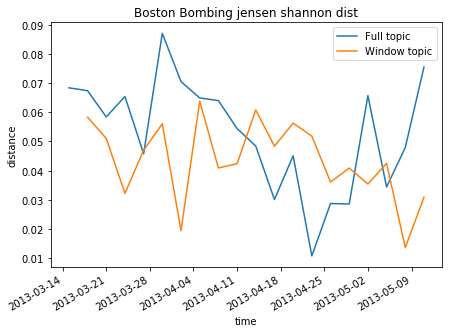

In [253]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(*zip(*get_vector_distances(vectors=boston_vecs, full_lda=boston_lda)), label='Full topic')
ax.plot(*zip(*get_vector_distances(vectors=boston_vecs)), label='Window topic')
ax.set_title('Boston Bombing jensen shannon dist')
ax.set_ylabel('distance')
ax.set_xlabel('time')
ax.legend()
fig.autofmt_xdate()

In [264]:
show_topics(boston_vecs)

2013-03-15
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   boston, massachusetts, lincoln, rhode, springfield, providence, salem, worcester, booth, randolph
   com, http, www, org, html, net, https, gov, php, edu
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   bus, express, transport, metro, transit, transportation, buses, routes, tram, route
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   bass, custom, ups, vintage, watt, upright, dunlop, pickup, walnut, combo
2013-03-18
   know, says, told, night, said, come, goi

   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   boston, massachusetts, lincoln, rhode, springfield, providence, salem, worcester, booth, randolph
   com, http, www, org, html, net, https, gov, php, edu
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   bus, express, transport, metro, transit, transportation, buses, routes, tram, route
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
2013-04-11
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   com, http, www, org, html, net, https, gov, php, edu
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   boston, massachusetts, lincoln, rhode, springfiel

   boston, massachusetts, lincoln, rhode, springfield, providence, salem, worcester, booth, randolph
   car, cars, driver, chevrolet, motor, speedway, toyota, drivers, nascar, auto
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   com, http, www, org, html, net, https, gov, php, edu
   bridge, tunnel, traffic, bridges, crossing, lanes, arch, span, river, toll
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   bus, express, transport, metro, transit, transportation, buses, routes, tram, route
   online, internet, content, facebook, media, twitter, available, social, websites, copyright
2013-05-05
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   com, http, www, org, html, net, https, gov, php, edu
   love, night, girl, let, baby, good, live, 

## Boston World Series

In [273]:
start_date = datetime.date(2013, 10, 1)
end_date = datetime.date(2013, 11, 30)
window_size = 3 # days

boston_series_lda, boston_series_vecs = get_topic_vectors(df=boston_series_df, start_date=start_date, 
                             end_date=end_date, post_length=30,
                             window_size=window_size)

In [274]:
show_topics(boston_series_vecs)

2013-10-01
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   boston, massachusetts, lincoln, rhode, springfield, providence, salem, worcester, booth, randolph
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   com, http, www, org, html, net, https, gov, php, edu
   car, cars, driver, chevrolet, motor, speedway, toyota, drivers, nascar, auto
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   bus, express, transport, metro, transit, transportation, buses, routes, tram, route
   street, avenue, neighborh

   bus, express, transport, metro, transit, transportation, buses, routes, tram, route
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   tells, goes, begins, takes, finds, gets, tries, help, comes, returns
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
2013-10-25
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   com, http, www, org, html, net, https, gov, php, edu
   announced, got, wanted, decided, revealed, going, week, good, start, months
   love, night, girl, let, baby, good, live, kiss, beautiful, come
   boston, massachusetts, lincoln, rhode, springfield, providence, salem, worcester, booth, randolph
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   bus, express, transport, metro, tran

   scene, scenes, featured, filmed, audience, production, filming, shown, footage, interview
   reception, reviews, review, wrote, gave, said, critics, positive, critical, described
   boston, massachusetts, lincoln, rhode, springfield, providence, salem, worcester, booth, randolph
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   bus, express, transport, metro, transit, transportation, buses, routes, tram, route
2013-11-18
   know, says, told, night, said, come, going, away, things, room
   guy, fun, happy, mad, big, pretty, dad, funny, parody, dirty
   announced, got, wanted, decided, revealed, going, week, good, start, months
   tax, pay, money, price, paid, income, budget, revenue, cost, costs
   fact, case, certain, question, necessary, matter, claim, possible, considered, principle
   allow, required, need, needed, possible, able, provide, available, allows, allowing
   com, http, www, org, html, net, https, gov, php, edu
   union, workers,

In [182]:
text = """Dozens of sign-wielding protesters — graduate students, librarians, lecturers, and even a city council member — gathered in the shade cast by the University of California Berkeley’s administration offices. They had a message to deliver to the university’s chancellor Carol Christ: fight the GOP’s plans to raise taxes for graduate students. Push for free public higher education.
“Carol Christ, come down! Carol Christ, come down! Carol Christ, come down!” they chanted outside the closed doors.
She didn’t. (She’s in Asia, a UC Berkeley spokesperson says.) So the protesters left her a note: two letters and a sign, taped to the building’s door. The sign was decorated with monopoly money in Berkeley’s signature blue and yellow. It asked in plain black letters: “What is the backup plan?”
"""
text ="Tigers with stripes like to go hunting in the forests of India."

text = """The iPhone X separates itself from Apple’s other iPhones with its larger, crisper, edge-to-edge display, novel face-unlocking feature, and new gesture-based user interface. It’s a different experience than other iPhones, and though it may take a day or two to get used to, it’s very intuitive once you do.

The iPhone X also separates itself from Apple's other iPhones with its very high starting price: $999 unlocked. This, more than anything else, is what caused some debate within The Verge. Are the additional features in the iPhone X really enough to justify the extra cost compared to an iPhone 8?
"""

text = "There are many shoes made out of leather. They can be used for running or walking"
tokens = tokenize(text)
bow_vector = id2word_wiki.doc2bow(tokens)
lda_vector = lda_model[bow_vector]

max_topic_id = max(lda_vector, key=lambda item: item[1])[0]

print ', '.join(item[0] for item in lda_model.show_topic(max_topic_id, topn=10))

run, running, ran, robinson, walk, runs, aaa, longest, rbi, rbis
